In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

def pull_data():
    df = pd.read_csv('../data/life-expectancy.csv')
    df = df.loc[df['Code'] == 'USA']
    df.reset_index(drop=True, inplace=True)
    df = df.drop(index =0) # drop the 1880 life expectancy data
    df = df.drop(index =1) # drop the 1890 life expectancy data
    df.rename(columns={"Period life expectancy at birth - Sex: total - Age: 0": "Life Expectancy",}, inplace = True)
    df.drop(columns=["Entity", "Code"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df 

ModuleNotFoundError: No module named 'statsmodels'

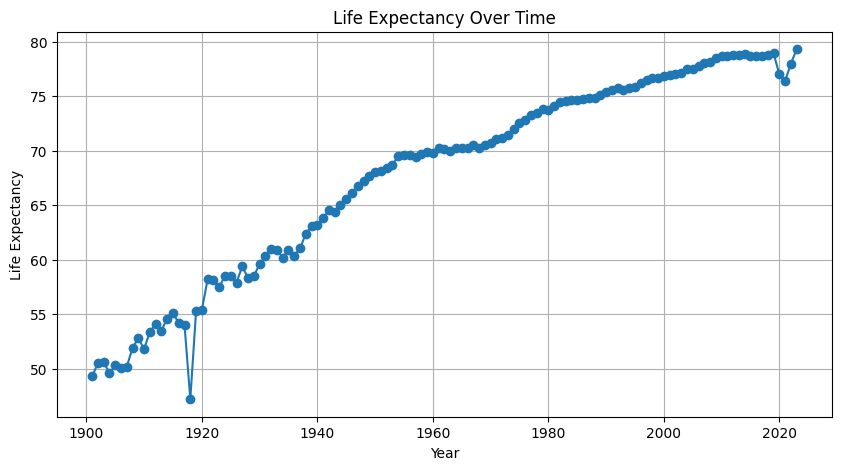

In [21]:
df = pull_data()

# plot life expectancy over time
plt.figure(figsize=(10,5))
plt.plot(df['Year'], df['Life Expectancy'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy Over Time')
plt.grid(True)
plt.show()

In [22]:
# Augmented Dickey-Fuller (FDA) test to check for stationarity
result_original = adfuller(df["Life Expectancy"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

# if p-value is less than 0.05, the data is stationary (contains no trend)
if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# apply second order differencing to remove trend
df['Life Expectancy_Diff'] = df['Life Expectancy'].diff().diff()

result_diff = adfuller(df['Life Expectancy_Diff'].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")

# check again for stationarity
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Original): -2.5285
p-value (Original): 0.1087
Interpretation: The original series is Non-Stationary.

ADF Statistic (Differenced): -6.2236
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


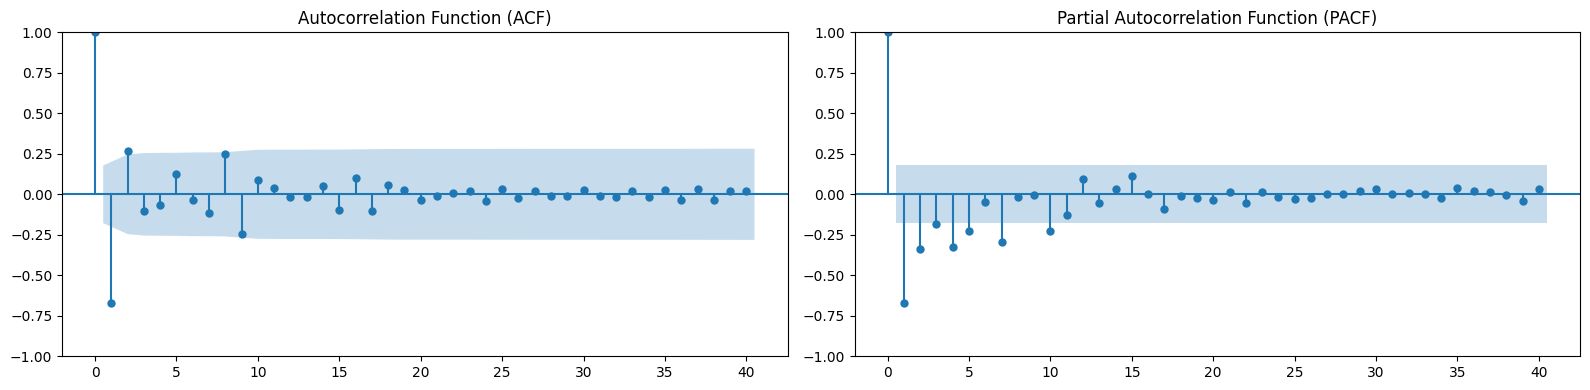

In [23]:
# ACF and PACF to help identify p and q values for ARIMA
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(df['Life Expectancy_Diff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(df['Life Expectancy_Diff'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# p --> 3 or 4 
# q --> 2 or 3 
# d --> 2

# (p, d, q)

In [60]:
# train test split
train = df[df['Year'] <= 1999]
test = df[df['Year'] >= 2000]

In [61]:
import warnings; warnings.simplefilter('ignore')

import itertools
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# tries different combinations of p, d, q using itertolls
p_range = range(0, 4)  
d_range = range(0, 4)  
q_range = range(0, 4) 

order_combinations = list(itertools.product(p_range, d_range, q_range))

train_data = train["Life Expectancy"]

results = []

# fits an ARIMA model for each combo and computes AIC and BIC
for order in order_combinations:
    try:
        model = ARIMA(train_data, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        bic = model_fit.bic
        results.append((order, aic, bic))
        print(f"ARIMA{order} - AIC: {aic:.2f}, BIC: {bic:.2f}")
    except:
        continue  

results_df = pd.DataFrame(results, columns=["Order", "AIC", "BIC"])

# selects the best ARIMA model based on the lowest AIC value
best_model = results_df.loc[results_df["AIC"].idxmin()]
print(f"\nBest ARIMA Order (by AIC): {best_model['Order']} with AIC: {best_model['AIC']:.2f}")

ARIMA(0, 0, 0) - AIC: 707.69, BIC: 712.88
ARIMA(0, 0, 1) - AIC: 603.25, BIC: 611.04
ARIMA(0, 0, 2) - AIC: 537.20, BIC: 547.58
ARIMA(0, 0, 3) - AIC: 470.87, BIC: 483.85
ARIMA(0, 1, 0) - AIC: 322.76, BIC: 325.34
ARIMA(0, 1, 1) - AIC: 314.54, BIC: 319.71
ARIMA(0, 1, 2) - AIC: 315.01, BIC: 322.77
ARIMA(0, 1, 3) - AIC: 315.50, BIC: 325.84
ARIMA(0, 2, 0) - AIC: 415.97, BIC: 418.54
ARIMA(0, 2, 1) - AIC: 322.04, BIC: 327.19
ARIMA(0, 2, 2) - AIC: 305.02, BIC: 312.74
ARIMA(0, 2, 3) - AIC: 306.46, BIC: 316.76
ARIMA(0, 3, 0) - AIC: 529.47, BIC: 532.04
ARIMA(0, 3, 1) - AIC: 419.26, BIC: 424.39
ARIMA(0, 3, 2) - AIC: 330.90, BIC: 338.59
ARIMA(0, 3, 3) - AIC: 315.32, BIC: 325.58
ARIMA(1, 0, 0) - AIC: 334.47, BIC: 342.26
ARIMA(1, 0, 1) - AIC: 326.43, BIC: 336.81
ARIMA(1, 0, 2) - AIC: 326.87, BIC: 339.84
ARIMA(1, 0, 3) - AIC: 327.37, BIC: 342.95
ARIMA(1, 1, 0) - AIC: 312.50, BIC: 317.67
ARIMA(1, 1, 1) - AIC: 314.23, BIC: 321.99
ARIMA(1, 1, 2) - AIC: 316.16, BIC: 326.50
ARIMA(1, 1, 3) - AIC: 317.30, BIC:

In [62]:
# trains model
best_model = ARIMA(train_data, order=(3,2,3))
best_model_fit = best_model.fit()

# forecast
forecast = best_model_fit.forecast(steps=len(test))
forecast.index = test['Year'].values  # ensure correct year indexing

test_life = test["Life Expectancy"][:len(forecast)]

In [63]:
# MAE calculation
mae = mean_absolute_error(test_life, forecast)
print(f"MAE: {mae:.4f}")

MAE: 2.0544


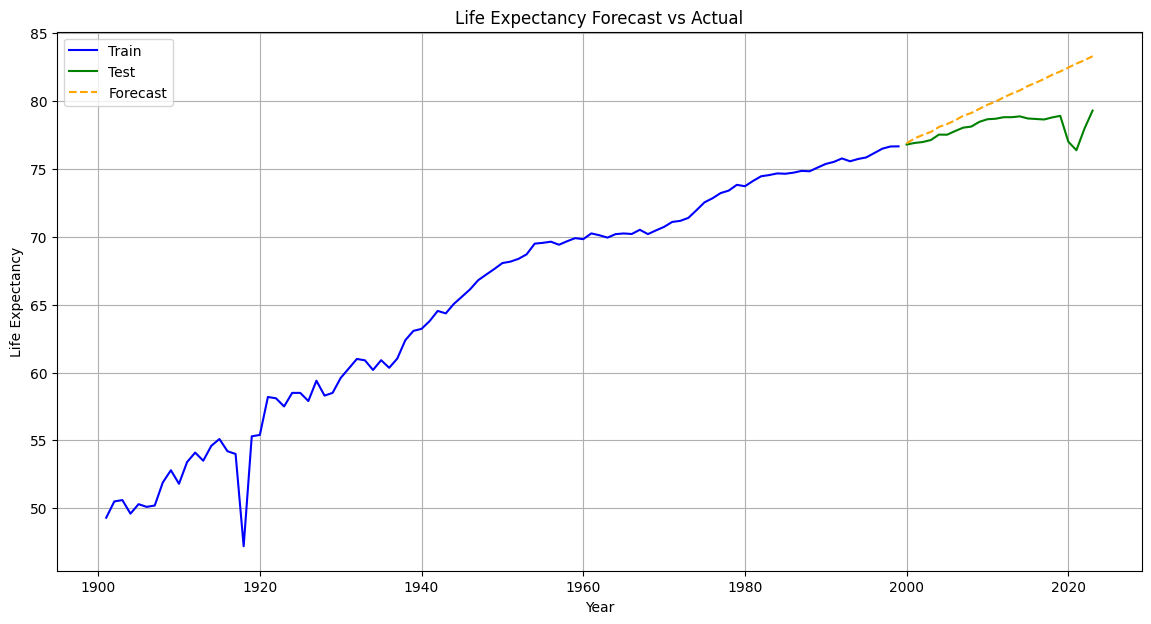

In [64]:
# plot actual vs predicted
plt.figure(figsize=(14, 7))
plt.plot(train['Year'], train["Life Expectancy"], label='Train', color='blue')
plt.plot(test['Year'], test["Life Expectancy"], label='Test', color='green')
plt.plot(test['Year'], forecast, label='Forecast', color='orange', linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

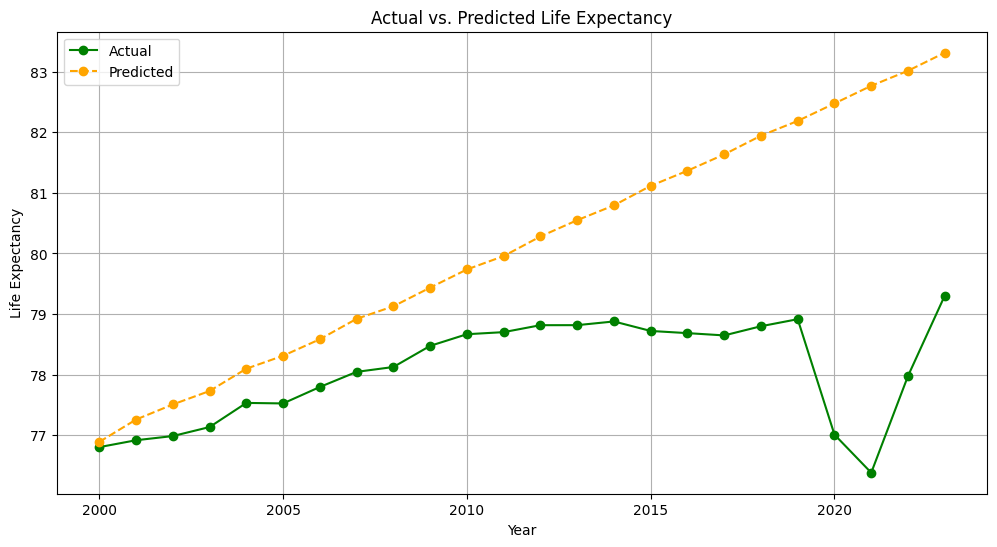

In [65]:
# plot actual vs predicted (just test years)
plt.figure(figsize=(12, 6))
plt.plot(test['Year'], test["Life Expectancy"], label='Actual', marker='o', linestyle='-', color='green')
plt.plot(test['Year'], forecast, label='Predicted', marker='o', linestyle='--', color='orange')
plt.xlabel('Year')
plt.ylabel('Life Expectancy')
plt.title('Actual vs. Predicted Life Expectancy')
plt.legend()
plt.grid(True)
plt.show()